<a href="https://www.kaggle.com/code/jatintec/data-science-championship?scriptVersionId=171880571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install --upgrade --force-reinstall nltk

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import os
from transformers import AutoTokenizer
from transformers import AutoModel
import itertools
import random

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

for dirname, _, filenames in os.walk('/kaggle/input/patent-classifier'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# EDA

## Loading data

In [4]:
train_path = "/kaggle/input/data-science-student-championship/train.csv"
test_path = "/kaggle/input/data-science-student-championship/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,Label,Content
0,2,second counting input 5 2 which receives inter...
1,4,extremely low temperature of the chips in cold...
2,3,of the basic ammonium salt of the carboxyl ate...
3,9,18 u2033 is provided which is axially supporte...
4,2,to an u201c inner surface u201d means the surf...


In [ ]:
# train_df['Label'].plot(kind='hist', bins=20, title='Label')
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [3]:
# train_df.groupby('Label').size()

Label
1    6756
2    6816
3    6059
4    5928
5    6467
6    6887
7    7143
8    7102
9    5961
dtype: int64

In [ ]:
# max_=0
# sum_=0
# for content in train_df["Content"]:
#     number_of_words = len(list(content.split(" ")))
#     if number_of_words>max_:
#         max_ = number_of_words
#     sum_ += number_of_words
# print(f"Max tokens: {max_}, Average tokens: {sum_/len(train_df['Content'])}")

In [ ]:
# word_counts = [len(text.split()) for text in train_df["Content"]]

# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Train Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [ ]:
# max_=0
# sum_=0
# for content in test_df["Content"]:
#     number_of_words = len(list(content.split(" ")))
#     if number_of_words>max_:
#         max_ = number_of_words
#     sum_ += number_of_words
# print(f"Max tokens: {max_}, Average tokens: {sum_/len(test_df['Content'])}")

In [ ]:
# word_counts = [len(text.split()) for text in test_df["Content"]]

# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Test Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [ ]:
# for label in (1, 2, 3, 4, 5, 6, 7, 8, 9):
#     train_word_freq = {}
#     for content in train_df[train_df['Label']==label]['Content']:
#         for word in content.split():
#             train_word_freq[word] = train_word_freq.get(word, 0) + 1
#     # Sort the dictionary by frequency
#     sorted_word_freq = sorted(train_word_freq.items(), key=lambda x: x[1], reverse=True)
#     print(f"Top 10 words with there frequinces: {sorted_word_freq[:10]}, Unique word count {len(sorted_word_freq)}")

In [ ]:
# test_word_freq = {}
# for content in test_df['Content']:
#     for word in content.split():
#         test_word_freq[word] = test_word_freq.get(word, 0) + 1

# # Sort the dictionary by frequency
# sorted_word_freq = sorted(test_word_freq.items(), key=lambda x: x[1], reverse=True)
# print(f"Top 10 words with there frequinces: {sorted_word_freq[:10]}, Unique word count {len(sorted_word_freq)}")

In [ ]:
# # Identify common words and compute their frequencies
# common_words_freq = {word: (train_word_freq[word], test_word_freq[word]) 
#                      for word in train_word_freq if word in test_word_freq}

# # Sort common words by their cumulative frequency (train + test)
# sorted_common_words_freq = sorted(common_words_freq.items(), 
#                                   key=lambda x: x[1][0] + x[1][1], 
#                                   reverse=True)

In [ ]:
# # Display the top 10 common words with their frequencies
# print(f"Top 10 common words with their frequencies: {sorted_common_words_freq[:10]}")
# print(f"Total unique common words: {len(sorted_common_words_freq)}")

In [ ]:
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()
# def preprocess_text(text):
#         # Lemmatize text and split into words
#         lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
#         # Remove stopwords and filter out less frequent words
#         filtered_words = [word for word in lemmatized_words if word not in stop_words and word in vocab]
#         # Rejoin words into a processed string
#         return ' '.join(filtered_words)

In [ ]:
# word_counts = [len(preprocess_text(text).split()) for text in train_df["Content"]]
# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Train Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [ ]:
# word_counts = [len(preprocess_text(text).split()) for text in test_df["Content"]]
# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Test Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

## Dataset Class

In [ ]:
# lemmatizer = WordNetLemmatizer()
# vocab_df = pd.concat([train_df, test_df], ignore_index=True)
# def build_vocab(texts, min_word_freq=1):
#     # Flatten all texts into a single list of words and lemmatize them
#     all_words = [lemmatizer.lemmatize(word.lower()) for text in texts for word in text.split()]
#     # Count word frequencies
#     word_freq = Counter(all_words)
#     # Filter words by minimum frequency
#     vocab = {word for word, freq in word_freq.items() if freq >= min_word_freq}
#     return vocab
# vocab = build_vocab(vocab_df['Content'].to_list())

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512, is_train=True):
        self.texts = texts
        self.labels = labels
        self.is_train = is_train
        self.tokenizer = tokenizer
        self.max_length = max_length
        if self.is_train:
            self.labels = [label - 1 for label in self.labels]
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }
        if self.is_train:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-large-en-v1.5")

# Convert labels to integers if they're not already (replace 'Label' with your actual label column name)
train_df['Label'] = train_df['Label'].astype(int)

train_dataset = TextDataset(
    texts=train_df["Content"].to_list(),
    labels=train_df["Label"].to_list(),
    tokenizer=tokenizer,
    max_length=256,
    is_train=True
)
# Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=16)

# # Iterate through Binary DataLoader
# for i, batch in enumerate(train_loader):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     labels = batch['labels']
    
#     # Print out shapes and some example data
#     print(f"Batch {i+1}")
#     print(f"Input IDs shape: {input_ids.shape}")
#     print(f"Attention Mask shape: {attention_mask.shape}")
#     print(f"Labels shape: {labels.shape}")
#     print(f"First input IDs: {input_ids[0][:12]}")
#     print(f"First Attention Mask: {attention_mask[0][:12]}")
#     print(f"Number of words", sum(attention_mask[0]))
#     print(f"First Label: {labels[i]}\n")
#     if i == 3:
#         break
# print(f"Length of dataset: ", len(train_dataset))

In [7]:
# Create Dataset
test_dataset = TextDataset(
    texts=test_df["Content"].to_list(),
    tokenizer=tokenizer,
    max_length=256,
    is_train=False
)
# test_loader = DataLoader(test_dataset, batch_size=16)
# Iterate through Binary DataLoader
# for i, batch in enumerate(test_loader):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
    
#     print(f"Batch {i+1}")
#     print(f"Binary Input IDs shape: {input_ids.shape}")
#     print(f"Binary Attention Mask shape: {attention_mask.shape}")
#     print(f"Binary First input IDs: {input_ids[0][:12]}")
#     print(f"Binary First Attention Mask: {attention_mask[0][:12]}")
#     print(f"Number of words", sum(attention_mask[0]))
    
#     if i == 3:
#         break
# print(f"Length of dataset: ", len(test_dataset))

## Define Model

In [8]:
scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
scibert.config.hidden_size

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

384

In [9]:
class SciBertEmbedder(nn.Module):
    def __init__(self):
        super(SciBertEmbedder, self).__init__()
        self.scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

    def forward(self, input_ids, attention_mask=None):
        with torch.no_grad():
            outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs[1]  # Output the [CLS] token embeddings

class Classifier(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_rate):
        super(Classifier, self).__init__()
        self.scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.scibert.config.hidden_size, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)      # Maintaining a funnel-like structure
        self.fc3 = nn.Linear(hidden_dim, output_dim)         # Output layer

    def forward(self, input_ids, attention_mask=None):
        outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc1(outputs[1])
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.gelu(x)        
        x = self.fc3(x)
        return x

class SciBertClassifier(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_rate, device):
        super(SciBertClassifier, self).__init__()
        self.classifier = Classifier(hidden_dim, output_dim, dropout_rate).to(device)
        self.device = device

    def forward(self, input_ids, attention_mask):
        output = self.classifier(input_ids.to(self.device), attention_mask.to(self.device))
        return output

In [10]:
# scibert = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5")
# scibert.to(device)
# progress_bar = tqdm(train_loader, desc=f"Test out")
# for batch in progress_bar:
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)
#     out = scibert(input_ids, attention_mask)
#     print(out)

## Load model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# from sklearn.utils.class_weight import compute_class_weight

# targets = train_df["Label"]
# # Assuming 'targets' contains your labels for the dataset
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [15]:
# class_weights_tensor

tensor([0.9723, 0.9637, 1.0841, 1.1081, 1.0157, 0.9538, 0.9196, 0.9249, 1.1020],
       device='cuda:0')

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(1, 10)

In [13]:
from sklearn.metrics import balanced_accuracy_score
def calculate_balanced_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_true = []

    with torch.no_grad():  # No need to track gradients for inference
        data_loader_tqdm = tqdm(data_loader, desc=f"Calculating Balanced Accuracy")
        for batch in data_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted_labels = torch.max(outputs, dim=1)

            # Move predicted and true labels to CPU and then convert to numpy for sklearn compatibility
            all_preds.extend(predicted_labels.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(all_true, all_preds)
    return balanced_accuracy, np.array(all_preds), np.array(all_true)

## Training Loop

In [14]:
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
epochs = 12
batch_size = 16
early_stopping_patience = 3
hidden_dim = 128
output_dim = 9
dropout_rate = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = range(1, 10)

class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0], device=device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

dataset_indices = list(range(len(train_dataset)))
targets = [train_dataset[i]['labels'].item() for i in dataset_indices]

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, targets)):
    print(f'Fold {fold + 1}/{k}')
    
    model = SciBertClassifier(hidden_dim, output_dim, dropout_rate, device)
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for batch in train_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        train_balanced_accuracy, train_preds, train_true = calculate_balanced_accuracy(model, train_loader, device)
        print(f"Balanced training accuracy: {train_balanced_accuracy:.4f}")
        
        # Calculate and plot training confusion matrix
#         train_cm = confusion_matrix(train_true, train_preds)
#         plt.figure(figsize=(10, 7))
#         plot_confusion_matrix(train_cm, classes=list(class_names), title=f'Training Confusion Matrix, Epoch {epoch+1}')
#         plt.show()

        model.eval()
        total_val_loss = 0
        val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        with torch.no_grad():
            for batch in val_loader_tqdm:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        val_balanced_accuracy, val_preds, val_true = calculate_balanced_accuracy(model, val_loader, device)
        print(f"Balanced validation accuracy: {val_balanced_accuracy:.4f}")
        
        # Calculate and plot validation confusion matrix
#         val_cm = confusion_matrix(val_true, val_preds)
#         plt.figure(figsize=(10, 7))
#         plot_confusion_matrix(val_cm, classes=list(class_names), title=f'Validation Confusion Matrix, Epoch {epoch+1}')
#         plt.show()
        
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            model_dir = f'/kaggle/working/model_checkpoints/fold_{fold + 1}'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            model_save_path = os.path.join(model_dir, f'model_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), model_save_path)
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Fold 1/10


Training Epoch 1:   0%|          | 0/3326 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference

In [19]:
# hidden_dim = 128
# output_dim = 9
# dropout_rate = 0.2
# model = SciBertClassifier(hidden_dim, output_dim, dropout_rate, device)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [20]:
# state_dict = torch.load("/kaggle/input/document-emb/pytorch/k1-e2/1/model_epoch_2(3).pth")
# model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
# train_balanced_accuracy, train_preds, train_true = calculate_balanced_accuracy(model, train_loader, device)

Calculating Balanced Accuracy:   0%|          | 0/3695 [00:00<?, ?it/s]

Confusion matrix, without normalization


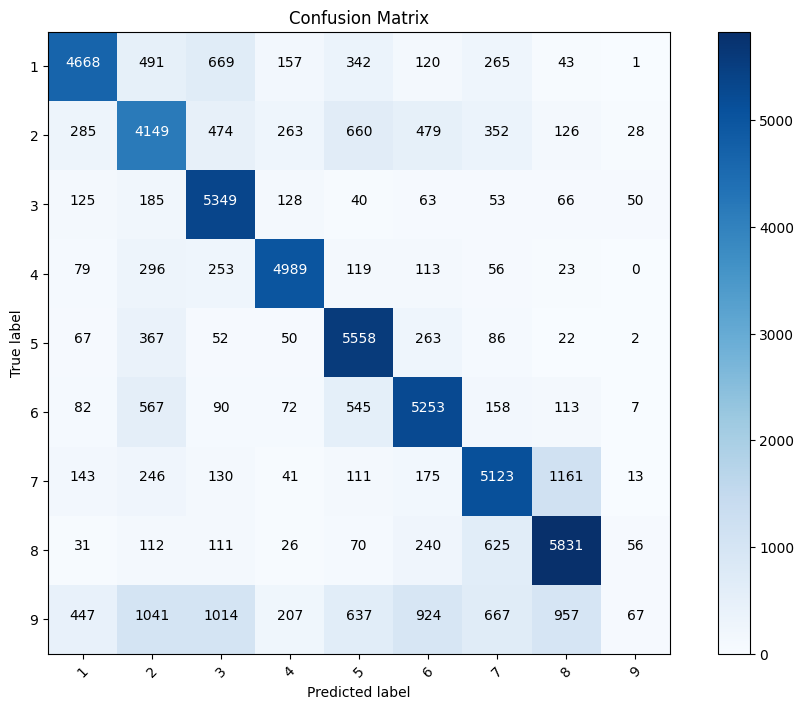

In [28]:
# class_names = range(1, 10)
# train_cm = confusion_matrix(train_true, train_preds)
# plt.figure(figsize=(10, 7))
# plot_confusion_matrix(train_cm, classes=list(class_names), title=f'Confusion Matrix')
# plt.show()

In [30]:
# train_cm

array([[4668,  491,  669,  157,  342,  120,  265,   43,    1],
       [ 285, 4149,  474,  263,  660,  479,  352,  126,   28],
       [ 125,  185, 5349,  128,   40,   63,   53,   66,   50],
       [  79,  296,  253, 4989,  119,  113,   56,   23,    0],
       [  67,  367,   52,   50, 5558,  263,   86,   22,    2],
       [  82,  567,   90,   72,  545, 5253,  158,  113,    7],
       [ 143,  246,  130,   41,  111,  175, 5123, 1161,   13],
       [  31,  112,  111,   26,   70,  240,  625, 5831,   56],
       [ 447, 1041, 1014,  207,  637,  924,  667,  957,   67]])